In [1]:
import wandb
import matplotlib.pyplot as plt
import dice_ml
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer, roc_auc_score,precision_score, recall_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
import os
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from scripts.SEP_CFE_functions import *

min_max_scaler = MinMaxScaler()
warnings.filterwarnings("ignore")
scale_factor = 1e3

In [2]:
abt_path_train = '../../data/GOES/goes18_2024.csv'
df_train = pd.read_csv(abt_path_train,  sep=',' )
df_train.columns.values[0] = 'timestamp'
df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])

In [3]:
def create_and_save_windows(df, save_dir="windows", input_hours=2, pred_hours=2, stride_hours=2):
    os.makedirs(save_dir, exist_ok=True)
    input_len = input_hours * 60     # convert to minutes
    pred_len = pred_hours * 60
    stride = stride_hours * 60
    n = len(df)
    timestamps = df['timestamp']
    window_count = 0

    for start in range(0, n - input_len - pred_len + 1, stride):
        end_input = start + input_len
        end_pred = end_input + pred_len

        input_df = df.iloc[start:end_input]
        pred_df  = df.iloc[end_input:end_pred]

        start_time = timestamps[start].strftime("%Y%m%d_%H%M")
        input_file = os.path.join(save_dir, f"GOES18_2024_{window_count:04d}_{start_time}_input.csv")
        pred_file  = os.path.join(save_dir, f"GOES18_2024_{window_count:04d}_{start_time}_pred.csv")

        input_df.to_csv(input_file)
        pred_df.to_csv(pred_file)
        window_count += 1
    print(f"✅ Created {window_count} overlapping windows in '{save_dir}'")

# Create and save windows with stride = 2 hours
create_and_save_windows(df_train, save_dir="../../data/processed/goes18_2024", input_hours=2, pred_hours=2, stride_hours=2)

✅ Created 4391 overlapping windows in '../../data/processed/goes18_2024'


In [4]:
def create_flare_label_dataset_from_pred(input_pred_dir, save_path=None):
    rows = []
    for file in sorted(os.listdir(input_pred_dir)):
        if file.endswith("_pred.csv"):
            pred_file_path = os.path.join(input_pred_dir, file)
            df_pred = pd.read_csv(pred_file_path)

            max_flux = df_pred['xrsb'].max()
            if max_flux >= 1e-4:
                label = 'X'
            elif max_flux >= 1e-5:
                label = 'M'
            elif max_flux >= 1e-6:
                label = 'C'
            elif max_flux >= 1e-7:
                label = 'B'
            elif max_flux >= 1e-8:
                label = 'A'
            else:
                label = 'NF'

            input_filename = file.replace('_pred', '_input')
            rows.append({'input_filename': input_filename, 'label': label})

    label_df = pd.DataFrame(rows)
    if save_path:
        label_df.to_csv(save_path, index=False)
        print(f"Label dataset saved to: {save_path}")

    return label_df


In [5]:
input_pred_dir = "../../data/processed/goes18_2024"
save_file = "../../data/processed/goes18_2024_labels.csv"

label_df = create_flare_label_dataset_from_pred(input_pred_dir, save_path=save_file)
print(label_df.head())

Label dataset saved to: ../../data/processed/goes18_2024_labels.csv
                             input_filename label
0  GOES18_2024_0000_20240101_0000_input.csv     C
1  GOES18_2024_0001_20240101_0200_input.csv     C
2  GOES18_2024_0002_20240101_0400_input.csv     C
3  GOES18_2024_0003_20240101_0600_input.csv     M
4  GOES18_2024_0004_20240101_0800_input.csv     C


In [6]:
# label_df = pd.read_csv("../../data/processed/goes18_2024_labels.csv")

In [7]:
def recursive_slices(start, end, min_size=5):
    length = end - start
    if length <= min_size:
        return [(start, end)]
    else:
        mid = start + length // 2
        left = recursive_slices(start, mid, min_size)
        right = recursive_slices(mid, end, min_size)
        return [(start, end)] + left + right

def generate_mean_features(df, min_size=5, prefix=None):
    n_timesteps = df.shape[0]
    slices = recursive_slices(0, n_timesteps, min_size)
    features = {}
    for channel in ['xrsa','xrsb']:
        # print(channel)
        data = pd.to_numeric(df[channel], errors='coerce').values
        for (s, e) in slices:
            name = f"{prefix+'_' if prefix else ''}{channel}[{s}:{e}]_mean"
            val = np.mean(data[s:e])
            features[name] = 0 if np.isnan(val) else val
    return pd.Series(features)


In [8]:
def create_mean_features_by_window_sizes(input_dir, output_file, window_sizes=None):
    rows = []
    input_files = sorted([f for f in os.listdir(input_dir) if "_input.csv" in f])
    for file in input_files:
        df = pd.read_csv(os.path.join(input_dir, file))
        features = generate_mean_features(df, min_size=5)
        feature_dict = {'input_filename': file, **features.to_dict()}
        rows.append(feature_dict)

    features_df = pd.DataFrame(rows)
    features_df.dropna(inplace=True)
    features_df.to_csv(output_file, index=False)
    print(f"✅ Mean-valued features saved to: {output_file}")


In [9]:
input_dir = "../../data/processed/goes18_2024/"  # folder containing input files
output_file = "../../data/processed/goes18_2024_mean_features_custom_windows.csv"

create_mean_features_by_window_sizes(input_dir, output_file)

✅ Mean-valued features saved to: ../../data/processed/goes18_2024_mean_features_custom_windows.csv


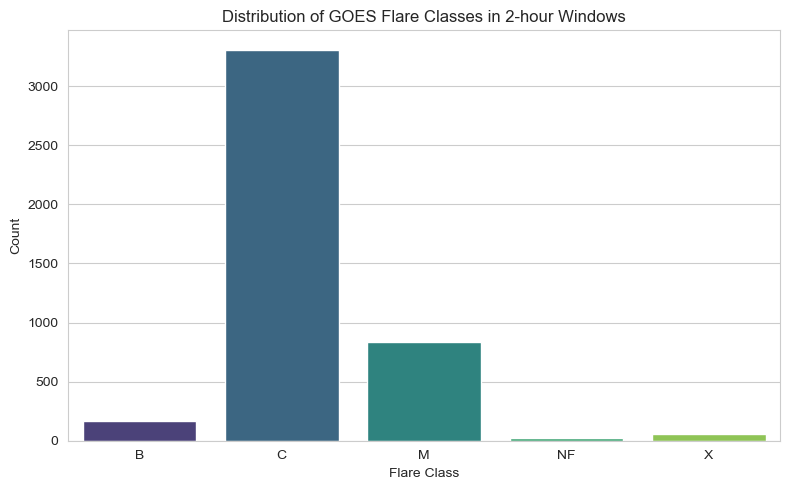

In [10]:
# Count of each flare type
flare_counts = label_df['label'].value_counts().sort_index()  # sort by label
plt.figure(figsize=(8,5))
sns.barplot(x=flare_counts.index, y=flare_counts.values, palette="viridis")
plt.xlabel("Flare Class")
plt.ylabel("Count")
plt.title("Distribution of GOES Flare Classes in 2-hour Windows")
plt.tight_layout()
plt.show()



In [11]:
features_file = "../../data/processed/goes18_2024_mean_features_custom_windows.csv"
features_df = pd.read_csv(features_file)
combined_df = pd.merge(features_df, label_df, on="input_filename", how="inner")

print("Combined dataset shape:", combined_df.shape)
print(combined_df.head())

# Optionally, save to CSV
combined_file = "../../data/processed/goes18_2024_features_labels.csv"
combined_df.to_csv(combined_file, index=False)
print(f"✅ Combined dataset saved to: {combined_file}")


Combined dataset shape: (4391, 128)
                             input_filename  xrsa[0:120]_mean  \
0  GOES18_2024_0000_20240101_0000_input.csv      1.177751e-07   
1  GOES18_2024_0001_20240101_0200_input.csv      2.562598e-08   
2  GOES18_2024_0002_20240101_0400_input.csv      9.965425e-09   
3  GOES18_2024_0003_20240101_0600_input.csv      1.561024e-08   
4  GOES18_2024_0004_20240101_0800_input.csv      5.757184e-07   

   xrsa[0:60]_mean  xrsa[0:30]_mean  xrsa[0:15]_mean  xrsa[0:7]_mean  \
0     1.585111e-07     2.000465e-07     2.360244e-07    2.621947e-07   
1     3.107531e-08     3.511606e-08     3.661682e-08    3.710156e-08   
2     1.090954e-08     1.257245e-08     1.304101e-08    1.300326e-08   
3     1.177995e-08     8.713668e-09     1.366712e-08    2.128694e-08   
4     9.745299e-07     2.278376e-07     3.499181e-07    4.294937e-07   

   xrsa[0:3]_mean  xrsa[3:7]_mean  xrsa[7:15]_mean  xrsa[7:11]_mean  ...  \
0    2.780908e-07    2.502726e-07     2.131253e-07     2.237296e

In [12]:
binary_map = {'NF': 0,'A': 0,'B': 0,'C': 0,'M': 1,'X': 1}
combined_df['binary_label'] = combined_df['label'].map(binary_map)
print(combined_df['binary_label'].value_counts())
print(combined_df[['label', 'binary_label']].head())
combined_file = "../../data/processed/goes18_2024_features_labels.csv"
combined_df.to_csv(combined_file, index=False)
print(f"✅ Combined dataset saved to: {combined_file}")


binary_label
0    3500
1     891
Name: count, dtype: int64
  label  binary_label
0     C             0
1     C             0
2     C             0
3     M             1
4     C             0
✅ Combined dataset saved to: ../../data/processed/goes18_2024_features_labels.csv


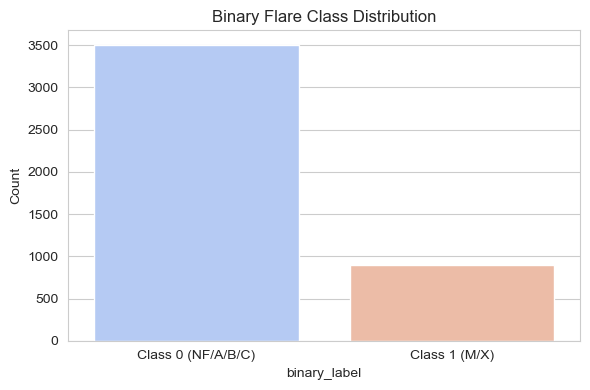

In [13]:
binary_counts = combined_df['binary_label'].value_counts().sort_index()

# Plot
plt.figure(figsize=(6,4))
sns.barplot(x=binary_counts.index, y=binary_counts.values, palette="coolwarm")
plt.xticks([0, 1], ["Class 0 (NF/A/B/C)", "Class 1 (M/X)"])
plt.ylabel("Count")
plt.title("Binary Flare Class Distribution")
plt.tight_layout()
plt.show()

In [14]:
def split_df_by_percentage(df, train_frac=0.7, val_frac=0.15, test_frac=0.15, random_state=42):
    if abs(train_frac + val_frac + test_frac - 1.0) > 1e-6:
        raise ValueError("Fractions must sum to 1.0")

    train_df, temp_df = train_test_split(df, train_size=train_frac, random_state=random_state, shuffle=True)
    temp_frac = test_frac / (val_frac + test_frac)
    val_df, test_df = train_test_split(temp_df, test_size=temp_frac, random_state=random_state, shuffle=True)
    return train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)


train_df, val_df, test_df = split_df_by_percentage(combined_df)

print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)
train_df = train_df[(train_df == 0).sum(axis=1) <= 10]
val_df = val_df[(val_df == 0).sum(axis=1) <= 10]
test_df = test_df[(test_df == 0).sum(axis=1) <= 10]
print("After dropping zero:")
print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)

Train shape: (3073, 129)
Validation shape: (659, 129)
Test shape: (659, 129)
After dropping zero:
Train shape: (2728, 129)
Validation shape: (580, 129)
Test shape: (580, 129)


In [15]:
feature_cols = [c for c in train_df.columns if c not in ['input_filename', 'label', 'binary_label']]

X_train = train_df[feature_cols].values * scale_factor
y_train = train_df['binary_label'].values

X_val = val_df[feature_cols].values * scale_factor
y_val = val_df['binary_label'].values

X_test = test_df[feature_cols].values *scale_factor
y_test = test_df['binary_label'].values

print("Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


Shapes:
X_train: (2728, 126) y_train: (2728,)
X_val: (580, 126) y_val: (580,)
X_test: (580, 126) y_test: (580,)


In [16]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_depth': [2, 3, 4, 5, 6, 7, 8]
}
rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scorer = make_scorer(f1_score, pos_label=1)

grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid,cv=cv,scoring=scorer,n_jobs=-1,verbose=1)

grid_search.fit(X_train, y_train)

# Print the best hyperparameters and corresponding score from cross-validation
print("Best parameters found:", grid_search.best_params_)
print("Best F1 score (for positive class) from CV:", grid_search.best_score_)

# Retrieve the best estimator and evaluate on the test data
best_rf = grid_search.best_estimator_
Y_pred = best_rf.predict(X_train)

# Save model
joblib.dump(best_rf, '../../models/RandomForestClassifier_model_goes18_xrs_cfe.pkl')

# Output the test classification report and confusion matrix
print("\nTest Classification Report:\n", classification_report(y_train, Y_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_train, Y_pred))

Fitting 5 folds for each of 42 candidates, totalling 210 fits
Best parameters found: {'max_depth': 7, 'n_estimators': 300}
Best F1 score (for positive class) from CV: 0.5534619498105913

Test Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.88      0.91      2144
           1       0.65      0.78      0.71       584

    accuracy                           0.86      2728
   macro avg       0.79      0.83      0.81      2728
weighted avg       0.87      0.86      0.87      2728

Test Confusion Matrix:
 [[1893  251]
 [ 127  457]]


In [17]:
overall_results = []
overall_results.append(('training set', TSS(y_train, Y_pred), HSS(y_train, Y_pred),accuracy_score(y_train, Y_pred),precision_score(y_train, Y_pred),f1_score(y_train, Y_pred),recall_score(y_train, Y_pred)))

y_val_pred = best_rf.predict(X_val)
overall_results.append(('validation set', TSS(y_val, y_val_pred), HSS(y_val, y_val_pred),accuracy_score(y_val, y_val_pred),precision_score(y_val, y_val_pred),f1_score(y_val, y_val_pred),recall_score(y_val, y_val_pred)))

y_test_pred = best_rf.predict(X_test)
overall_results.append(('testing set', TSS(y_test, y_test_pred), HSS(y_test, y_test_pred),accuracy_score(y_test, y_test_pred),precision_score(y_test, y_test_pred),f1_score(y_test, y_test_pred),recall_score(y_test, y_test_pred)))
print(pd.DataFrame(overall_results, columns=["Dataset",  "TSS", "HSS","Accuracy","Precision Score","F1_score","Recall_score"]))


          Dataset       TSS       HSS  Accuracy  Precision Score  F1_score  \
0    training set  0.665463  0.617745  0.861437         0.645480  0.707430   
1  validation set  0.373656  0.353915  0.770690         0.468531  0.501873   
2     testing set  0.496387  0.441863  0.808621         0.493056  0.561265   

   Recall_score  
0      0.782534  
1      0.540323  
2      0.651376  


                Feature  Importance
125  xrsb[116:120]_mean    0.066510
123  xrsb[112:120]_mean    0.053149
62   xrsa[116:120]_mean    0.050795
119  xrsb[105:120]_mean    0.039609
111   xrsb[90:120]_mean    0.038558
124  xrsb[112:116]_mean    0.034572
48    xrsa[90:120]_mean    0.028518
60   xrsa[112:120]_mean    0.027495
56   xrsa[105:120]_mean    0.023901
61   xrsa[112:116]_mean    0.021756
95    xrsb[60:120]_mean    0.019184
63     xrsb[0:120]_mean    0.018555
32    xrsa[60:120]_mean    0.017655
122  xrsb[108:112]_mean    0.016890
120  xrsb[105:112]_mean    0.016527
115    xrsb[93:97]_mean    0.013698
118  xrsb[101:105]_mean    0.013062
0      xrsa[0:120]_mean    0.012308
112   xrsb[90:105]_mean    0.010169
105    xrsb[75:82]_mean    0.009146


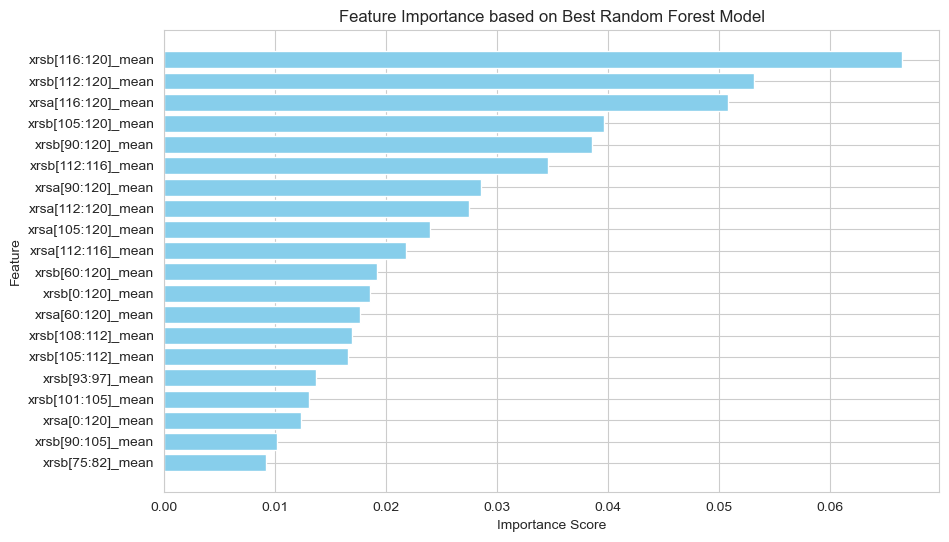

In [18]:
feature_importances = best_rf.feature_importances_
cont_features = list(combined_df.drop(["input_filename","label","binary_label"],axis=1).columns)
feature_importance_df = pd.DataFrame({
    'Feature': cont_features,
    'Importance': feature_importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)
print(feature_importance_df)


plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance based on Best Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

Creating DiCE Counterfactual Explainers for SEP Prediction

In [19]:
df_cfe = test_df.drop(["label","input_filename"],axis=1)
df_cfe['binary_label']=df_cfe['binary_label'].astype(float)


In [20]:
# --- Clean continuous features so every column has a visible decimal part ---
for col in cont_features:
    # Force float, replace inf/nan
    df_cfe[col] = pd.to_numeric(df_cfe[col], errors='coerce').fillna(0).astype(float)
    # Round and force decimal representation
    df_cfe[col] = df_cfe[col].apply(lambda x: float(f"{x:.10f}"))

# Optional: ensure scientific notation doesn’t hide decimals
pd.options.display.float_format = '{:.10f}'.format

print("✅ Cleaned df_cfe ready for DiCE:", df_cfe.shape)


✅ Cleaned df_cfe ready for DiCE: (580, 127)


In [21]:
print(df_cfe.dtypes)       # all float64
print(df_cfe.isna().sum()) # all zeros
print(df_cfe.head())
df_cfe.columns
# shows decimal format


xrsa[0:120]_mean      float64
xrsa[0:60]_mean       float64
xrsa[0:30]_mean       float64
xrsa[0:15]_mean       float64
xrsa[0:7]_mean        float64
                       ...   
xrsb[108:112]_mean    float64
xrsb[112:120]_mean    float64
xrsb[112:116]_mean    float64
xrsb[116:120]_mean    float64
binary_label          float64
Length: 127, dtype: object
xrsa[0:120]_mean      0
xrsa[0:60]_mean       0
xrsa[0:30]_mean       0
xrsa[0:15]_mean       0
xrsa[0:7]_mean        0
                     ..
xrsb[108:112]_mean    0
xrsb[112:120]_mean    0
xrsb[112:116]_mean    0
xrsb[116:120]_mean    0
binary_label          0
Length: 127, dtype: int64
   xrsa[0:120]_mean  xrsa[0:60]_mean  xrsa[0:30]_mean  xrsa[0:15]_mean  \
0      0.0000000092     0.0000000120     0.0000000126     0.0000000147   
1      0.0000001063     0.0000001048     0.0000000415     0.0000000265   
2      0.0000000285     0.0000000420     0.0000000621     0.0000000436   
3      0.0000000942     0.0000000696     0.0000000799    

Index(['xrsa[0:120]_mean', 'xrsa[0:60]_mean', 'xrsa[0:30]_mean',
       'xrsa[0:15]_mean', 'xrsa[0:7]_mean', 'xrsa[0:3]_mean', 'xrsa[3:7]_mean',
       'xrsa[7:15]_mean', 'xrsa[7:11]_mean', 'xrsa[11:15]_mean',
       ...
       'xrsb[97:101]_mean', 'xrsb[101:105]_mean', 'xrsb[105:120]_mean',
       'xrsb[105:112]_mean', 'xrsb[105:108]_mean', 'xrsb[108:112]_mean',
       'xrsb[112:120]_mean', 'xrsb[112:116]_mean', 'xrsb[116:120]_mean',
       'binary_label'],
      dtype='object', length=127)

In [22]:
# import dice_ml.data_interfaces.public_data_interface as pdi
#
# def safe_get_decimal_precisions(self, output_type="dict"):
#     precisions = {}
#     for col in self.data_df.columns:
#         if self.data_df[col].dtype in [np.float32, np.float64]:
#             modes = self.data_df[col].mode()
#             if len(modes) == 0:
#                 precisions[col] = 6
#                 continue
#             val_str = str(modes[0])
#             precisions[col] = len(val_str.split('.')[1]) if '.' in val_str else 6
#         else:
#             precisions[col] = 6
#     return precisions
#
# pdi.PublicData.get_decimal_precisions = safe_get_decimal_precisions
# print("✅ Patched DiCE precision function safely.")


In [23]:
cont_features = list(combined_df.drop(["input_filename","label","binary_label"],axis=1).columns)
for feat in cont_features:
    df_cfe[feat]=df_cfe[feat].astype(float)
data= dice_ml.Data(dataframe=df_cfe, continuous_features=cont_features, outcome_name="binary_label")

In [33]:
# Reset the data interface with proper ranges
feature_ranges = {}
for col in cont_features:
    min_val = float(df_cfe[col].min())
    max_val = float(df_cfe[col].max())
    # Add small buffer to prevent edge cases
    feature_ranges[col] = [min_val - 0.000001, max_val + 0.000001]

# Create data interface with ranges
data = dice_ml.Data(
    dataframe=df_cfe,
    continuous_features=cont_features,
    outcome_name="binary_label",
    permitted_range=feature_ranges
)

In [34]:
# Create model wrapper
cfe_model = dice_ml.Model(
    model=best_rf,
    backend="sklearn",
    model_type='classifier'
)

# Create genetic explainer with specific parameters
exp_genetic = dice_ml.Dice(
    data_interface=data,
    model_interface=cfe_model,
    method="genetic"
)

In [30]:
def get_query_instance(query_ts_filename, df_combined_labels, model):
    """
    Retrieve the query instance and its target label for a given filename.

    Args:
           query_ts_filename (str): The filename identifying the query instance.
           df_combined_labels (pd.DataFrame): DataFrame containing labeled data.
           model: A trained classifier with a `.predict()` method.

    Returns:
        Tuple[pd.DataFrame, Any]: The query instance (features only) and its true label.
     """
    query_instance_raw = df_combined_labels[df_combined_labels['input_filename'] == query_ts_filename]
    query_instance = query_instance_raw.drop(["label", 'input_filename','binary_label'], axis=1)*scale_factor
    query_instance = query_instance.fillna(0)
    true_label = query_instance_raw["binary_label"].values[0]
    predicted_label = model.predict(query_instance)

    print("Target value for the query instance:\n", true_label)
    print("Predicted value:\n", predicted_label)

    return query_instance, true_label, predicted_label

In [27]:
import dice_ml.data_interfaces.public_data_interface as pdi

def safe_get_decimal_precisions(self, output_type="dict"):
    """Safe version of get_decimal_precisions that handles edge cases"""
    precisions = {}
    for col in self.data_df.columns:
        if self.data_df[col].dtype in [np.float32, np.float64]:
            modes = self.data_df[col].mode()
            if len(modes) == 0 or '.' not in str(modes[0]):
                precisions[col] = 6  # default precision
            else:
                val_str = str(modes[0])
                precisions[col] = len(val_str.split('.')[1])
        else:
            precisions[col] = 6  # default precision
    return precisions

# Patch the DiCE library
pdi.PublicData.get_decimal_precisions = safe_get_decimal_precisions

In [31]:
query_ts1_filename ='GOES18_2024_3628_20241029_0800_input.csv'
# query_ts1_filename ='GOES18_2024_4390_20241231_2000_input.csv'
# query_ts1_filename ='GOES18_2024_0026_20240103_0400_input.csv'
query_instance1, target_val1,predicted_val= get_query_instance(query_ts1_filename, df_combined_labels=combined_df, model=best_rf)
query_instance1 = query_instance1.astype(float)
query_instance1 = query_instance1.fillna(0)

Target value for the query instance:
 0
Predicted value:
 [0]


In [36]:
# Generate counterfactuals
cfe_genetic = exp_genetic.generate_counterfactuals(
    query_instance1,
    total_CFs=4,
    desired_class=1,
    proximity_weight=0.5,
    diversity_weight=1.0,
    categorical_penalty=0.1,
    algorithm="genetic",
    verbose=False
)

  0%|          | 0/1 [00:00<?, ?it/s]


KeyError: 0

In [25]:
df_cfe.head()

,xrsa[0:120]_mean,xrsa[0:60]_mean,xrsa[0:30]_mean,xrsa[0:15]_mean,xrsa[0:7]_mean,xrsa[0:3]_mean,xrsa[3:7]_mean,xrsa[7:15]_mean,xrsa[7:11]_mean,xrsa[11:15]_mean,...,xrsb[97:101]_mean,xrsb[101:105]_mean,xrsb[105:120]_mean,xrsb[105:112]_mean,xrsb[105:108]_mean,xrsb[108:112]_mean,xrsb[112:120]_mean,xrsb[112:116]_mean,xrsb[116:120]_mean,binary_label
0,0.0000000092,0.0000000120,0.0000000126,0.0000000147,0.0000000175,0.0000000179,0.0000000173,0.0000000122,0.0000000143,0.0000000101,...,0.0000014508,0.0000014495,0.0000014425,0.0000014633,0.0000014373,0.0000014827,0.0000014243,0.0000014437,0.0000014050,0.0000000000
1,0.0000001063,0.0000001048,0.0000000415,0.0000000265,0.0000000327,0.0000000375,0.0000000291,0.0000000211,0.0000000230,0.0000000191,...,0.0000031357,0.0000030529,0.0000032817,0.0000032318,0.0000031572,0.0000032877,0.0000033254,0.0000033158,0.0000033350,0.0000000000
2,0.0000000285,0.0000000420,0.0000000621,0.0000000436,0.0000000332,0.0000000297,0.0000000358,0.0000000528,0.0000000431,0.0000000625,...,0.0000017682,0.0000017766,0.0000018039,0.0000017869,0.0000017729,0.0000017974,0.0000018189,0.0000018255,0.0000018122,0.0000000000
3,0.0000000942,0.0000000696,0.0000000799,0.0000000878,0.0000000954,0.0000001025,0.0000000900,0.0000000813,0.0000000809,0.0000000816,...,0.0000055052,0.0000054217,0.0000046488,0.0000048258,0.0000050461,0.0000046606,0.0000044940,0.0000043920,0.0000045959,1.0000000000
4,0.0000001324,0.0000001752,0.0000002553,0.0000002953,0.0000003365,0.0000003669,0.0000003137,0.0000002593,0.0000002744,0.0000002442,...,0.0000033144,0.0000032013,0.0000028247,0.0000029071,0.0000029743,0.0000028567,0.0000027527,0.0000027911,0.0000027142,0.0000000000


In [26]:
# Ensure all features have proper decimal representation
for col in cont_features:
    df_cfe[col] = df_cfe[col].apply(lambda x: float(f"{x:.6f}"))

In [28]:
cfe_model = dice_ml.Model(model=best_rf, backend="sklearn", model_type='classifier')
exp_random = dice_ml.Dice(data_interface=data, model_interface=cfe_model, method="random") #method= ["genetic","kdtree","random"]

joblib.dump(exp_random, "../../models/goes18_xrs_2024_cfe_random_explainer.pkl")

print("\nRandom Dice explainer created successfully.\n")


Random Dice explainer created successfully.



In [29]:
#Define a Model object using dice_ml.Model (we are using this CFE model for regressor type of prediction model
cfe_model = dice_ml.Model(model=best_rf, backend="sklearn", model_type='classifier')
#Create the Dice explainer
exp_genetic = dice_ml.Dice(data_interface=data, model_interface=cfe_model, method="genetic") #method= ["genetic","kdtree","random"]

# Save the explainer (DiCE model) using joblib
joblib.dump(exp_genetic, "../../models/goes18_xrs_2024_cfe_genetic_explainer.pkl")

#use `exp` to generate counterfactual explanations
print("\nGenetic Dice explainer created successfully.\n")


Genetic Dice explainer created successfully.



In [32]:
cfe_exp=[]
cfe_genetic = exp_genetic.generate_counterfactuals(
    query_instance1,  #multiple query instances can be provided as an input dataframe
    total_CFs=4,  # Number of counterfactual examples to generate
    desired_class=1#'opposite' #,  # Specify the desired class for a continuous target variable
    )
cfe_genetic.visualize_as_dataframe(show_only_changes=True)
cfe_df = cfe_genetic.cf_examples_list[0].final_cfs_df

# df_cfe_exp


  0%|          | 0/1 [00:00<?, ?it/s]


KeyError: 0